<a href="https://colab.research.google.com/github/sjg230/QCES_LNM/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [114]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [169]:
#@title Explicit Euler function
def EE(x, t, kappa, output=True):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    if (output==True):
      print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [170]:
#@title Crank-Nicholson function
def CN(x, t, kappa, output=True):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()

    # Print the elapsed time if output is set to true

    if (output==True):
      print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$C(x,t) = \left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [117]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [118]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [119]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.06 seconds


and finally, plot the results side-by-side

In [120]:
# Plot the results

def plot_diffusion():
  plt.figure(figsize=(14, 6))

  plt.subplot(1, 2, 1)
  plt.pcolormesh(x, t, c_EE.T, shading='auto')
  plt.xlabel('x')
  plt.ylabel('t')
  plt.title('Explicit Euler')

  plt.subplot(1, 2, 2)
  plt.pcolormesh(x, t, c_CN.T, shading='auto')
  plt.xlabel('x')
  plt.ylabel('t')
  plt.title('Crank-Nicolson')

  plt.tight_layout()
  plt.show()

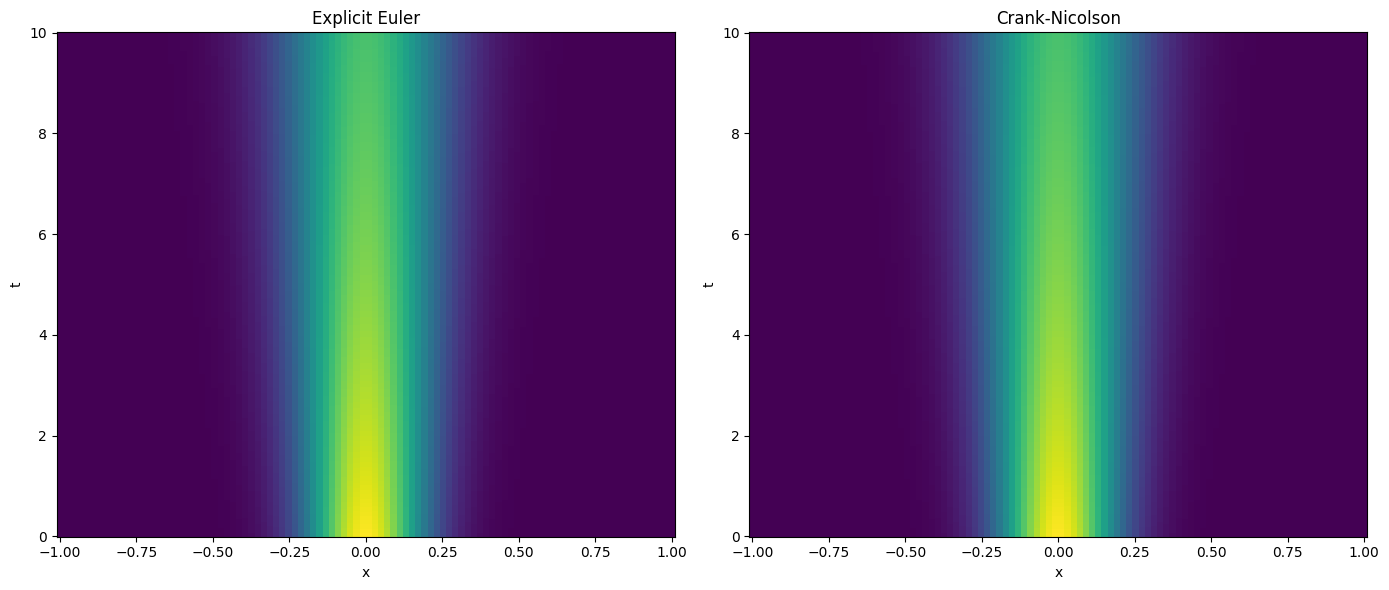

In [121]:
plot_diffusion()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing the timestep (reduce the number of timesteps) and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.07 seconds


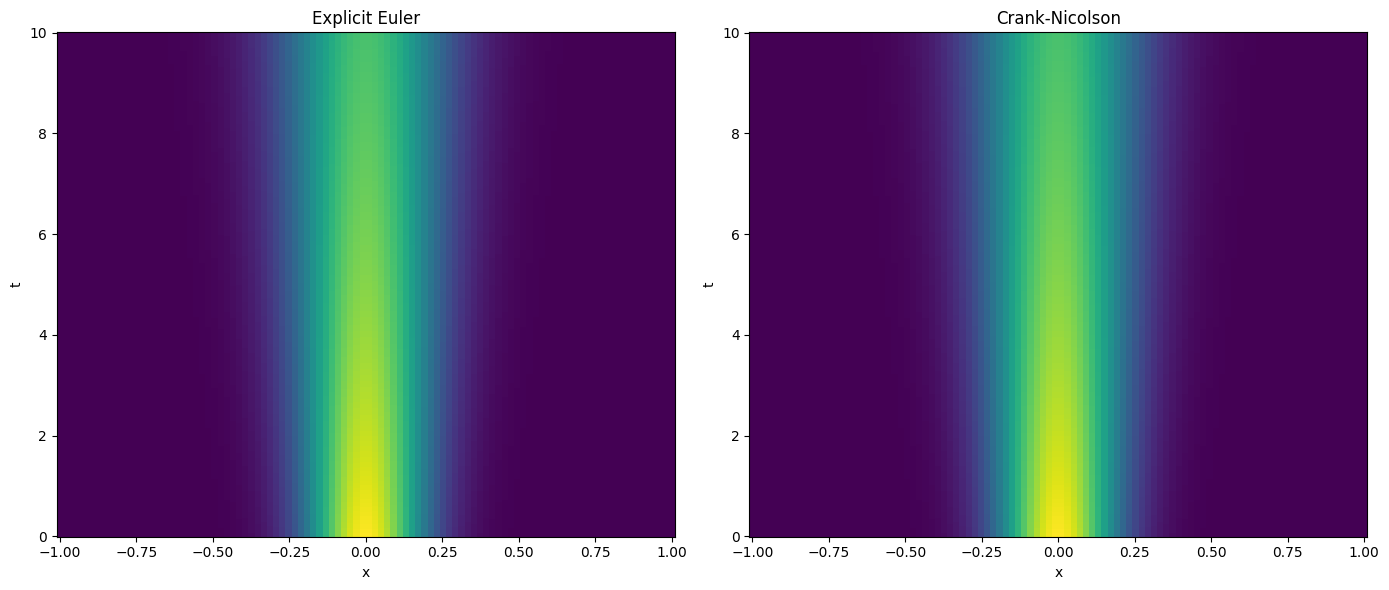

In [122]:
# Reduce number of timesteps, Nt, and the grid spacing, Nx
Nt = 1000
Nx = 100

# To see any differences in the stability, we need to have a greater rate of diffusion
kappa = 0.001

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson
plot_diffusion()

The Crank-Nicholson method has coped with the increase in diffusivity, and produces a sensible graph of one-dimensional diffusion. By contrast the explict Euler method has broken down, 'blowing up' the numerical approximation on which the Euler method depends.

The timestep, and grid spacing, need to be smaller (more resolved) for a given diffusivity, for the explicit Euler method, than for the Crank-Nicholson method. **Crank-Nicholson is more stable.**

| Value of kappa     | Result (with Nt=1000, Nx=100)      |
| ------------- | ------------- |
| 0.001 | Both methods yield sensible graphs, no obvious differences |
| 0.01 | Both work, but explicit Euler has appeared to show faster diffusion |
| 0.1 | Explicit Euler has broken; Crank-Nicholson still works |
| 1 | Explicit Euler has broken; Crank-Nicholson still works, though with some apparent artefacts |
| 10 | Both have now broken |

Eventually even the Crank-Nicholson breaks down, but John says that is due to improper imposition of the boundary conditions, leading to flux at the boundary becoming important.

Increasing Nt by a factor of 10 when kappa = 0.1 partially rescues the Euler solution, but it still appears to contain artefacts, and is substantially different from the Crank-Nicholson solution.

Reducing Nx leads to blockiness (reduced resoluion) and accentuates the effect of faster apparent diffusion with the explict Euler method.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

In [123]:
# Add code to plot exact and numerical solutions
# t=20 for the exact solution corresponds to t=10 for the numerical solutions
def exact_soln(x, kappa):
  C = np.zeros(len(x))
  # for i in range(1, len(t)):
  #   C[i,] = (1/(4*np.pi*kappa*t[i]))**(0.5)*(np.exp((-x**2)/(4*kappa*t[i])))
  C_exact = (1/(4*np.pi*kappa*20))**(0.5)*(np.exp((-x**2)/(4*kappa*20)))
  return C_exact

In [127]:
C_exact = exact_soln(x,kappa)

Text(0.5, 1.0, 'Comparison of solutions at t=10')

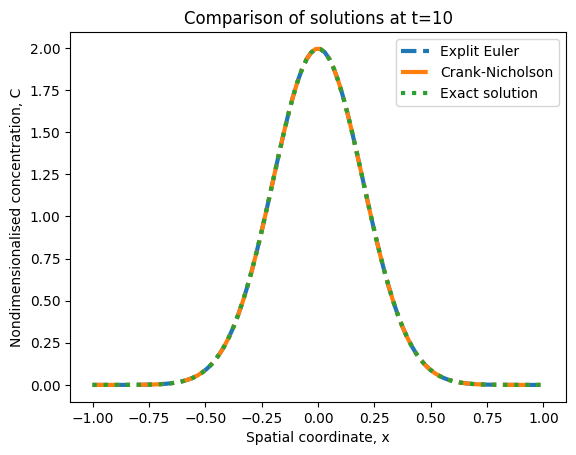

In [128]:
fig, ax = plt.subplots()
ax.plot(x, c_EE.T[-1], label='Explit Euler', linestyle='--', lw=3)
ax.plot(x, c_CN.T[-1], label='Crank-Nicholson', linestyle='dashdot', lw=3)
ax.plot(x, C_exact, label='Exact solution', linestyle='dotted', lw=3)
ax.set_xlabel('Spatial coordinate, x')
ax.set_ylabel('Nondimensionalised concentration, C')
ax.legend()
ax.set_title('Comparison of solutions at t=10')

The three solutions are visually indistinguishable.

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

A standard measure of model success is root mean squared error (RMSE) which is defined as follows:

$$\text{RMSE} = \sqrt{\frac{\sum_{i=0}^{N - 1} (\text{modelvalue}_i- \text{exactvalue}_i)^2}{N}}$$

where $N$ is the number of values. Pick a value of $t$ to compare the solutions at - here I choose $t=10$, as that is what is plotted on the comparison graph above.
</span>

In [129]:
# Calculate just for the values shown in the plot above.

def RMSE(model, exact):
  return np.sqrt(np.sum((model-exact)**2)/len(model))

print("The root-mean squared error for the Explicit Euler numerical solution is " + str(RMSE(c_EE.T[-1], C_exact)))
print("The root-mean squared error for the Crank-Nicolson numerical solution is " + str(RMSE(c_CN.T[-1], C_exact)))

The root-mean squared error for the Explicit Euler numerical solution is 0.00038868549532786195
The root-mean squared error for the Crank-Nicolson numerical solution is 0.00045549340707854395


In [130]:
# Run the simulations for multiple values of Nx

# Reset Nt
Nt = 1000
t = np.linspace(t_start, t_end, Nt)

# Define Nx's range

Nx_range  = np.linspace(10, 400, 50)
RMSE_Nx_EE = np.zeros(len(Nx_range))
RMSE_Nx_CN = np.zeros(len(Nx_range))

for i, Nx in enumerate(Nx_range):

  x = np.linspace(x_start, x_end, int(Nx))  # Create a vector for x

  # Run the simulations
  c_EE = EE(x, t, kappa, False) # explicit Euler
  c_CN = CN(x, t, kappa, False) # Crank-Nicolson
  C_exact = exact_soln(x,kappa) # exact solution with correct number of spatial steps

  RMSE_Nx_EE[i] = RMSE(c_EE.T[-1], C_exact)
  RMSE_Nx_CN[i] = RMSE(c_CN.T[-1], C_exact)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


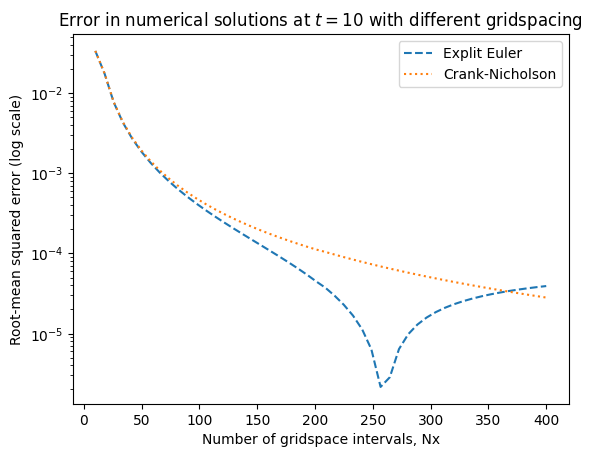

In [131]:
# Plot the variation of RMSE with Nx on a logarithmic scale
fig, ax = plt.subplots()
ax.plot(Nx_range, RMSE_Nx_EE, label='Explit Euler', linestyle='--')
ax.plot(Nx_range, RMSE_Nx_CN, label='Crank-Nicholson', linestyle='dotted')
# ax.scatter(Nx_range, RMSE_Nx_EE, label='Explit Euler', s=1)
# ax.scatter(Nx_range, RMSE_Nx_CN, label='Crank-Nicholson', s=1)
ax.set_yscale('log')
ax.set_xlabel('Number of gridspace intervals, Nx')
ax.set_ylabel('Root-mean squared error (log scale)')
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_title('Error in numerical solutions at $t=10$ with different gridspacing')
ax.legend()

<ipython-input-129-d7af9951fc81>:4: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum((model-exact)**2)/len(model))
<ipython-input-169-7674dd936ecf>:26: RuntimeWarning: invalid value encountered in add
  c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]


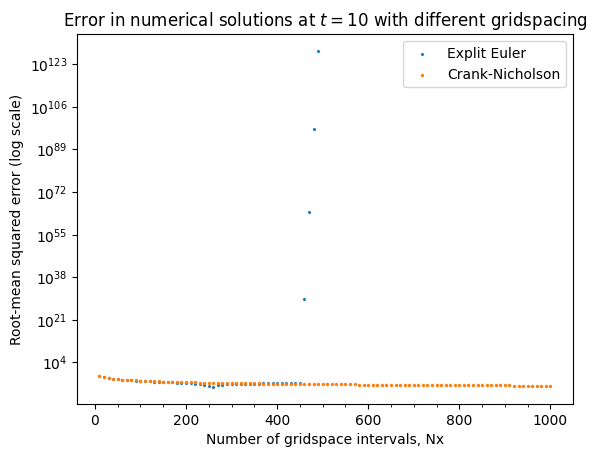

In [171]:
#@title And again but showing the blow-up of Explicit Euler at large Nx - note the vertical axis

# Reset Nt
Nt = 1000
t = np.linspace(t_start, t_end, Nt)

Nx_range  = np.linspace(10, 1000, 100)
RMSE_Nx_EE = np.zeros(len(Nx_range))
RMSE_Nx_CN = np.zeros(len(Nx_range))

for i, Nx in enumerate(Nx_range):

  x = np.linspace(x_start, x_end, int(Nx))  # Create a vector for x

  # Run the simulations
  c_EE = EE(x, t, kappa, False) # explicit Euler
  c_CN = CN(x, t, kappa, False) # Crank-Nicolson
  C_exact = exact_soln(x,kappa) # exact solution with correct number of spatial steps

  RMSE_Nx_EE[i] = RMSE(c_EE.T[-1], C_exact)
  RMSE_Nx_CN[i] = RMSE(c_CN.T[-1], C_exact)

# Plot the variation of RMSE with Nx on a logarithmic scale
fig, ax = plt.subplots()
# ax.plot(Nx_range, RMSE_Nx_EE, label='Explit Euler', linestyle='--')
# ax.plot(Nx_range, RMSE_Nx_CN, label='Crank-Nicholson', linestyle='dotted')
ax.scatter(Nx_range, RMSE_Nx_EE, label='Explit Euler', marker='x', s=2)
ax.scatter(Nx_range, RMSE_Nx_CN, label='Crank-Nicholson', s=2)
ax.set_yscale('log')
ax.set_xlabel('Number of gridspace intervals, Nx')
ax.set_ylabel('Root-mean squared error (log scale)')
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_title('Error in numerical solutions at $t=10$ with different gridspacing')
ax.legend()

In [133]:
# Now do the same but varying Nt instead of Nx

# Restore Nx
Nx = 100
x = np.linspace(x_start, x_end, Nx)

# Vary Nt and compute the RMSE

Nt_range  = np.linspace(10, 1000, 100)

RMSE_Nt_EE = np.zeros(len(Nt_range))
RMSE_Nt_CN = np.zeros(len(Nt_range))

for i, Nt in enumerate(Nt_range):

  t = np.linspace(t_start, t_end, int(Nt))  # Create a vector of times

  # Run the simulations
  c_EE = EE(x, t, kappa, output=False) # explicit Euler
  c_CN = CN(x, t, kappa, output=False) # Crank-Nicolson
  C_exact = exact_soln(x,kappa) # exact solution with correct number of spatial steps

  RMSE_Nt_EE[i] = RMSE(c_EE.T[-1], C_exact)
  RMSE_Nt_CN[i] = RMSE(c_CN.T[-1], C_exact)

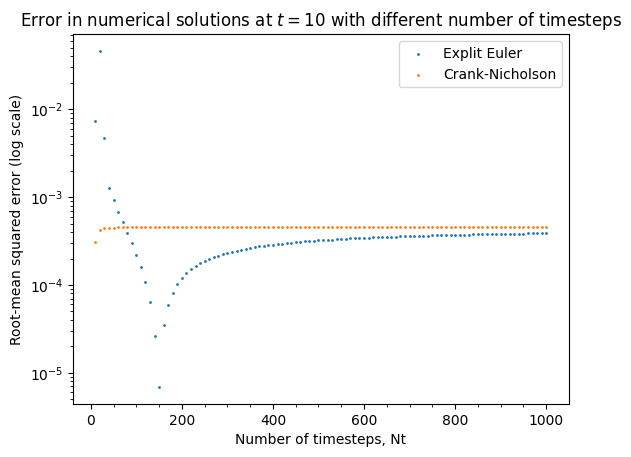

In [134]:
# Plot the variation of RMSE with Nt on a logarithmic scale
fig, ax = plt.subplots()
# ax.plot(Nx_range, RMSE_Nt_EE, label='Explit Euler', linestyle='--')
# ax.plot(Nx_range, RMSE_Nt_CN, label='Crank-Nicholson', linestyle='dotted')
ax.scatter(Nt_range, RMSE_Nt_EE, label='Explit Euler', s=1)
ax.scatter(Nt_range, RMSE_Nt_CN, label='Crank-Nicholson', s=1)
ax.set_yscale('log')
ax.set_xlabel('Number of timesteps, Nt')
ax.set_ylabel('Root-mean squared error (log scale)')
ax.set_title('Error in numerical solutions at $t=10$ with different number of timesteps')
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.legend()

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

In [172]:
#@title Functions for CN and EE which return time taken

def EE_time(x, t, kappa, output=True):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    if (output==True):
      print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return (c, (end_time - start_time))

def CN_time(x, t, kappa, output=True):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    if (output==True):
      print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return (c, (end_time-start_time))

In [173]:
#@title Run the simulations for multiple values of Nx and Nt, and record time taken

# Nx
#####

# Reset Nt
Nt = 1000
t = np.linspace(t_start, t_end, Nt)

Nx_range  = np.linspace(10, 400, 50)
RMSE_time_Nx_EE = [np.zeros(len(Nx_range)), np.zeros(len(Nx_range))]
RMSE_time_Nx_CN = [np.zeros(len(Nx_range)), np.zeros(len(Nx_range))]

for i, Nx in enumerate(Nx_range):

  x = np.linspace(x_start, x_end, int(Nx))  # Create a vector for x

  # Run the simulations, and store the (concentration, time_taken) tuples
  c_EE = EE_time(x, t, kappa, output=False) # explicit Euler (c,time_taken)
  c_CN = CN_time(x, t, kappa, output=False) # Crank-Nicolson (c,time_taken)
  C_exact = exact_soln(x,kappa) # exact solution with correct number of spatial steps

  RMSE_time_Nx_EE[0][i] = RMSE(c_EE[0].T[-1], C_exact) # index 0 accesses and records the model output
  RMSE_time_Nx_CN[0][i] = RMSE(c_CN[0].T[-1], C_exact)

  # Record time taken

  RMSE_time_Nx_EE[1][i] = c_EE[1] # index 1 accesses and records the time taken to run the model
  RMSE_time_Nx_CN[1][i] = c_CN[1]

# Nt
####

# Restore Nx
Nx = 100
x = np.linspace(x_start, x_end, Nx)

# Vary Nt and compute the RMSE

Nt_range  = np.linspace(10, 1000, 100)

RMSE_time_Nt_EE = [np.zeros(len(Nt_range)), np.zeros(len(Nt_range))]
RMSE_time_Nt_CN = [np.zeros(len(Nt_range)), np.zeros(len(Nt_range))]

for i, Nt in enumerate(Nt_range):

  t = np.linspace(t_start, t_end, int(Nt))  # Create a vector of times

  # Run the simulations
  c_EE = EE_time(x, t, kappa, output=False) # explicit Euler
  c_CN = CN_time(x, t, kappa, output=False) # Crank-Nicolson
  C_exact = exact_soln(x,kappa) # exact solution with correct number of spatial steps

  RMSE_time_Nt_EE[0][i] = RMSE(c_EE[0].T[-1], C_exact)
  RMSE_time_Nt_CN[0][i] = RMSE(c_CN[0].T[-1], C_exact)

  # Record time taken

  RMSE_time_Nt_EE[1][i] = c_EE[1] # index 1 accesses and records the time taken to run the model
  RMSE_time_Nt_CN[1][i] = c_CN[1]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


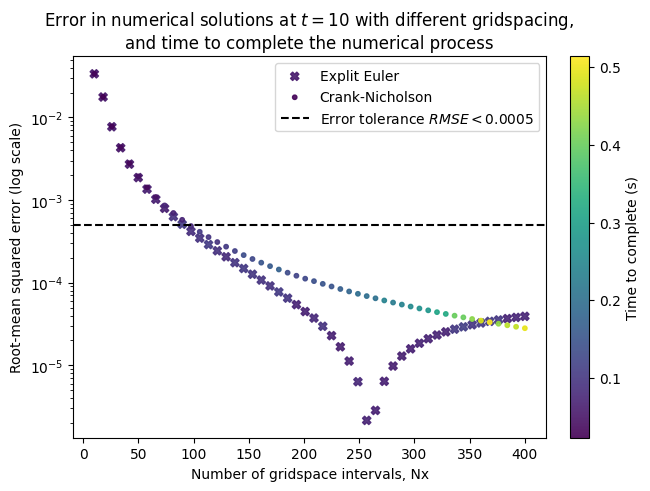

In [167]:
#@title Plot the variation of RMSE with Nx on a logarithmic scale, with colour representing time taken
fig, ax = plt.subplots(constrained_layout=True)

# Set a consistent colour scale by determining the min and max times across both numerical methods
min_time = min(min(RMSE_time_Nx_EE[1]), min(RMSE_time_Nx_CN[1]))
max_time = max(max(RMSE_time_Nx_EE[1]), max(RMSE_time_Nx_CN[1]))
# ax.plot(Nx_range, RMSE_Nx_EE, label='Explit Euler', linestyle='--')
# ax.plot(Nx_range, RMSE_Nx_CN, label='Crank-Nicholson', linestyle='dotted')
sc1 = ax.scatter(Nx_range, RMSE_time_Nx_EE[0], label='Explit Euler', marker='X', alpha=0.9, c=RMSE_time_Nx_EE[1], vmin=min_time, vmax=max_time)
sc2 = ax.scatter(Nx_range, RMSE_time_Nx_CN[0], label='Crank-Nicholson', s=10, alpha=0.9, c=RMSE_time_Nx_CN[1], vmin=min_time, vmax=max_time)
ax.set_yscale('log')
ax.set_xlabel('Number of gridspace intervals, Nx')
ax.set_ylabel('Root-mean squared error (log scale)')
ax.axhline(0.0005, label='Error tolerance $RMSE<0.0005$',c='black', linestyle='--')
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_title('Error in numerical solutions at $t=10$ with different gridspacing, \nand time to complete the numerical process')
ax.legend()
fig.colorbar(sc1, label='Time to complete (s)')

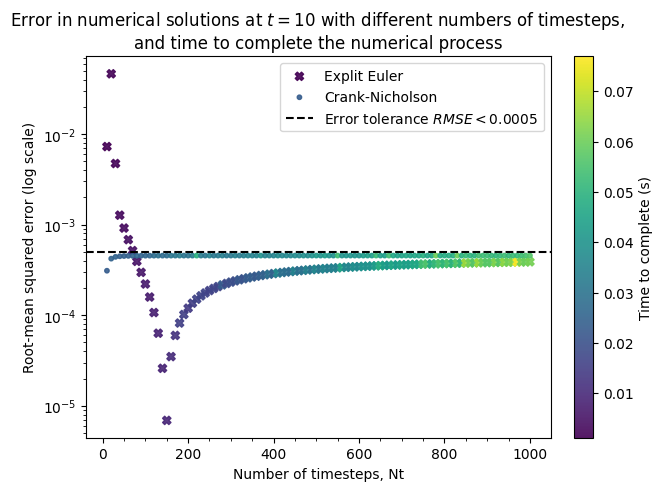

In [166]:
#@title Plot the same as above but for Nt
fig, ax = plt.subplots(constrained_layout=True)

# Set a consistent colour scale by determining the min and max times across both numerical methods
min_time = min(min(RMSE_time_Nt_EE[1]), min(RMSE_time_Nt_CN[1]))
max_time = max(max(RMSE_time_Nt_EE[1]), max(RMSE_time_Nt_CN[1]))
# ax.plot(Nt_range, RMSE_Nt_EE, label='Explit Euler', linestyle='--')
# ax.plot(Nt_range, RMSE_Nt_CN, label='Crank-Nicholson', linestyle='dotted')
sc1 = ax.scatter(Nt_range, RMSE_time_Nt_EE[0], label='Explit Euler', marker='X', alpha=0.9, c=RMSE_time_Nt_EE[1], vmin=min_time, vmax=max_time)
sc2 = ax.scatter(Nt_range, RMSE_time_Nt_CN[0], label='Crank-Nicholson', s=10, alpha=0.9, c=RMSE_time_Nt_CN[1], vmin=min_time, vmax=max_time)
ax.set_yscale('log')
ax.set_xlabel('Number of timesteps, Nt')
ax.set_ylabel('Root-mean squared error (log scale)')
ax.axhline(0.0005, label='Error tolerance $RMSE<0.0005$',c='black', linestyle='--')
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_title('Error in numerical solutions at $t=10$ with different numbers of timesteps, \nand time to complete the numerical process')
ax.legend()
fig.colorbar(sc1, label='Time to complete (s)')

With an arbitrary error tolerance $RMSE < 0.0005$, shown in the plots above as the dashed black line, Explicit Euler is faster with all but the greatest number of timesteps, and is the faster option for all gridspacing for which it does not blow up ($Nx \lesssim 400$). Crank-Nicholson's speed increases with Nx.

The behaviour of Crank-Nicholson's error is more predictable, with no local minimum as seen in Explict Euler. It takes longer but is much more reliable, and beyond $Nt \approx 100$ the error appears independent of timestep, shown by the flatlining on the graph above.

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?